In [3]:
# prompt: import all necessary libraries for resnet16

!pip install torch torchvision
!pip install timm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder,StandardScaler
from torch.utils.data import DataLoader
import seaborn as sns
from zipfile import ZipFile
import timm

In [6]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:03<00:00, 40.6MB/s]
100% 2.29G/2.29G [01:03<00:00, 38.5MB/s]


In [7]:
file = 'chest-xray-pneumonia.zip'
with ZipFile(file , 'r') as f:
    filenames = f.namelist()

In [16]:
filenames[0:5]

['chest_xray/__MACOSX/._chest_xray',
 'chest_xray/__MACOSX/chest_xray/._.DS_Store',
 'chest_xray/__MACOSX/chest_xray/._test',
 'chest_xray/__MACOSX/chest_xray/._train',
 'chest_xray/__MACOSX/chest_xray/test/._.DS_Store']

In [8]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')
data_folder = Path('/content')
base_folder = Path('/content/drive/MyDrive/data')
data_folder = data_folder/'pneumonia_classification'
model_folder = base_folder/'models/pneumonia_classification'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_folder.mkdir(exist_ok=True)
model_folder.mkdir(exist_ok=True, parents=True)

In [10]:
with ZipFile(file ,'r') as f:
 f.extractall(path = data_folder)

In [11]:
# Resnet50 Model
IMAGE_SIZE=(224,224)
num_epochs = 10
batch_size = 64
learning_rate = 0.001
train_path = '/content/pneumonia_classification/chest_xray/chest_xray/train'
valid_path = '/content/pneumonia_classification/chest_xray/chest_xray/val'

In [12]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [13]:
train_dt=datasets.ImageFolder(train_path,transform=transform)
valid_dt=datasets.ImageFolder(valid_path,transform=transform)

In [14]:
# prompt: train_dt view the images
def show_images_from_imagefolder(dataset, num_images=5):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Mapping from label index to class name (assumes classes are sorted alphabetically)
    class_names = dataset.classes

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Change channel order for imshow
        label = labels[i].item()  # Get the label index

        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.show()

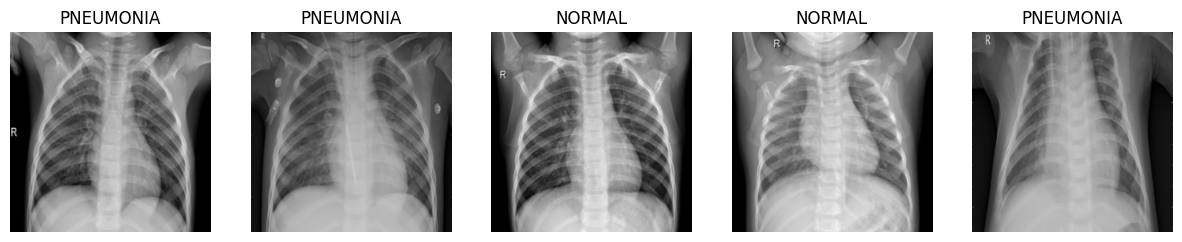

In [15]:
show_images_from_imagefolder(train_dt, num_images=5)

In [16]:
# Normalizing the inputs

mean = 0.0
std = 0.0
nb_samples = 0
dataloader = DataLoader(dataset=train_dt,batch_size=batch_size,shuffle=True)
# iterate through the dataset
for data in dataloader:
    images, labels = data
    batch_samples=images.size(0)
    images=images.view(batch_samples,images.size(1),-1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples
mean /= nb_samples
std /= nb_samples


In [17]:
print(mean)
print(std)

tensor([0.4823, 0.4823, 0.4823])
tensor([0.2216, 0.2216, 0.2216])


In [18]:
transform_norm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.482, 0.482, 0.482], [0.222, 0.224, 0.224])
])

In [19]:
train_dt=datasets.ImageFolder(train_path,transform=transform_norm)
valid_dt=datasets.ImageFolder(valid_path,transform=transform_norm)
dataloader = DataLoader(dataset=train_dt,batch_size=batch_size,shuffle=True)

In [20]:
# Load the ResNet50 model
model = torchvision.models.resnet50(pretrained=True)
# Since resnet50 is trained on imagenet with 1000 target labels
# Modify the final fully connected layer output to 2
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


In [22]:
# prompt: view the labels size

labels_size = len(train_dt.targets)
print(f"Labels size: {labels_size}")


Labels size: 5216


In [24]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model to run on the device
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model...
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
      inputs=inputs.to(device)
      labels=labels.to(device)

      # zero out the optimizer
      optimizer.zero_grad()

      # forward pass
      outputs=model(inputs)
      loss=criterion(outputs,labels)

      # Backward Pass
      loss.backward()
      optimizer.step()

      # Print the loss for every epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


Epoch 1/10, Loss: 0.0359
Epoch 2/10, Loss: 0.2617
Epoch 3/10, Loss: 0.0216
Epoch 4/10, Loss: 0.0515
Epoch 5/10, Loss: 0.0191
Epoch 6/10, Loss: 0.0170
Epoch 7/10, Loss: 0.0504
Epoch 8/10, Loss: 0.0091
Epoch 9/10, Loss: 0.2310
Epoch 10/10, Loss: 0.0010


In [25]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [26]:
valid_loader = DataLoader(dataset=valid_dt,batch_size=batch_size,shuffle=True)
# check the accuracy on train dataset
model.eval()
with torch.no_grad():  # save memory during inference
  train_acc = compute_accuracy(model, dataloader, device=device)
  valid_acc = compute_accuracy(model, valid_loader, device=device)
  print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} 'f'| Train: {train_acc :.2f}% 'f'| Validation: {valid_acc :.2f}%')


Epoch: 010/010 | Train: 99.41% | Validation: 93.75%


In [27]:
# prompt: Load the test set and compute the model's accuracy

test_path = '/content/pneumonia_classification/chest_xray/chest_xray/test'
test_dt = datasets.ImageFolder(test_path, transform=transform_norm)
test_loader = DataLoader(dataset=test_dt, batch_size=batch_size, shuffle=True)

# Check the accuracy on test dataset
model.eval()
with torch.no_grad():  # save memory during inference
  test_acc = compute_accuracy(model, test_loader, device=device)
  print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} 'f'| Test: {test_acc :.2f}%')


Epoch: 010/010 | Test: 75.16%
